In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv('Gaussian_noise.csv', header = None)

In [3]:
x = np.array(data[[0]])
t = np.array(data[[1]])

Text(0.5, 1.0, 'Dataset')

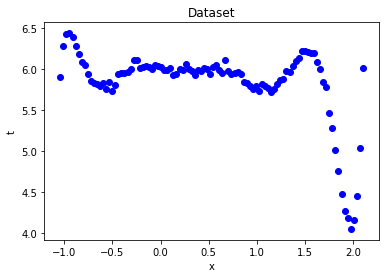

In [4]:
plt.figure()
plt.scatter(x,t, c='b')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Dataset')
#plt.savefig('100/raw_data.png')

In [5]:
def moore_penrose(phi,lambd=0):
    temp = np.linalg.inv(lambd*np.identity(phi.shape[1]) + np.dot(phi.T, phi))
    mpi = np.dot(temp, phi.T)
    return mpi

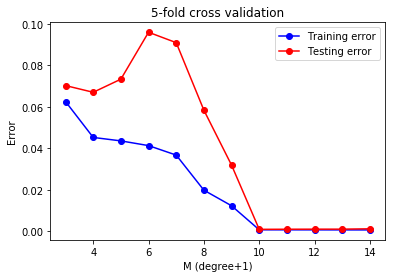

In [6]:
# K fold cross validation for M
N = 100
K = 5
data_shuffled = np.concatenate([x[:N],t[:N]], axis = 1)
#np.random.shuffle(data_shuffled)

train_err = []
test_err = []
for i in range(3,15):
    tr_e = 0
    te_e = 0
    for j in range(K):
        train = np.concatenate([data_shuffled[:j*(N//K)], data_shuffled[(j+1)*(N//K):]])
        test = data_shuffled[j*(N//K) : (j+1)*(N//K)]
        x_train = train[:,0]
        t_train = train[:,1]
        x_test = test[:,0]
        t_test = test[:,1]
        
        design_matrix_train = np.zeros((N-N//K,i))
        for a in range(N-N//K):
            for b in range(i):
                design_matrix_train[a,b] = x_train[a]**b
                
        design_matrix_test = np.zeros((N//K,i))
        for a in range(N//K):
            for b in range(i):
                design_matrix_test[a,b] = x_test[a]**b
               
        w_mp = np.dot(moore_penrose(design_matrix_train), t_train)
        y_mp_train = np.dot(design_matrix_train,w_mp)
        y_mp_test = np.dot(design_matrix_test,w_mp)
        tr_e += (0.5 * (np.sum(np.square(y_mp_train - t_train)))) / (N-N//K)
        te_e += (0.5 * (np.sum(np.square(y_mp_test - t_test)))) / (N//K)
        
    train_err.append(tr_e/K)
    test_err.append(te_e/K)

xa = np.arange(3,15)
plt.plot(xa,train_err,'-ob', label = "Training error")
plt.plot(xa,test_err,'-or', label = "Testing error")
plt.xlabel('M (degree+1)')
plt.ylabel('Error')
#plt.ylim((-0.01,1))
#plt.xticks(xa[::2])
plt.title(str(K) + '-fold cross validation')
plt.legend()
#plt.savefig('100/all_5_fold_cv_M.png')


In [7]:
N = 100
M = 10     # degree + 1
design_matrix = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        design_matrix[i,j] = x[i]**j

In [8]:
from math import ceil

def plot_error(err_list):
    xa = np.linspace(1,len(err_list),len(err_list),dtype=int)
    plt.figure(figsize=(15,5))
    plt.plot(xa[::500],err_list[::500])
    plt.xlabel('iterations')
    plt.ylabel('error')
    plt.title('Error vs iterations')
    #plt.savefig('100/sgd.png')
    #plt.show()

def gradient_descent(phi, labels, learning_rate, batch_size, iterations, M, lambd = 0, err_func = "mse"):
    w = np.zeros((M,1))
    num_batches = ceil(phi.shape[0]/batch_size)
    #print("Number of batches = ",num_batches)
    err_list = []
    for i in range(iterations):
        for j in range(num_batches):
            batch_phi = phi[j*batch_size:(j+1)*batch_size][:]
            batch_labels = labels[j*batch_size:(j+1)*batch_size]
            batch_labels = batch_labels.reshape(len(batch_labels),1)
            
            y = np.dot(batch_phi,w)
            
            if err_func is "mse":
                err = 0.5 * (np.sum(np.square(y - batch_labels)) + lambd*np.sum(np.square(w))) / len(batch_labels)
                grad = (np.dot(batch_phi.T,(y - batch_labels)) + lambd*np.sum(w)) / len(batch_labels)
                
            if err_func is "mae":
                sgn = np.sign(y - batch_labels)
                err = np.sum(np.abs(y - batch_labels)) / len(batch_labels)
                grad = np.sum((batch_phi*sgn).T, axis = 1) / len(batch_labels)
                grad = grad.reshape((M,1))
                
            w = w - learning_rate*grad
            
        if err_func is "mse":
            err_list.append(0.5 * (np.sum(np.square(np.dot(phi,w) - labels)) + lambd*np.sum(np.square(w))) / len(labels))
        if err_func is "mae":
            err_list.append(np.sum(np.abs((np.dot(phi,w)) - labels)) / len(labels))
            
    return (w,err_list)

def linear_regression(phi,labels,lambd=0):
    
    w_moore = np.dot(moore_penrose(phi,lambd), labels)

    learning_rate = 5e-5 
    batch_size = 50
    iterations = 100000
    err_func = "mse"
    w_grad, err_list = gradient_descent(phi, labels, learning_rate, batch_size, iterations, M, lambd, err_func)
    
    plot_error(err_list)
    
    return [w_moore, w_grad]

([<matplotlib.axis.XTick at 0x249c33cdb00>,
 <a list of 50 Text xticklabel objects>)

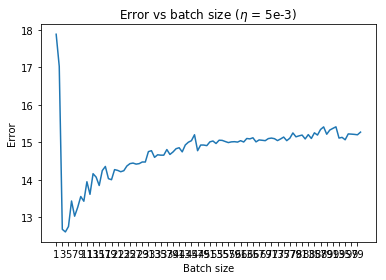

In [9]:
# plot batch size vs error
learning_rate = 5e-5
iterations = 100
lamd = 0
err_func = "mae"
xa = []
ya = []
for i in range(1,N+1):
    batch_size = i
    w_grad, err_list = gradient_descent(design_matrix[:N,:], t[:N], learning_rate, batch_size, iterations, M, lamd, err_func)
    ya.append(0.5 * (np.sum(np.square(np.dot(design_matrix,w_grad) - t[:N]))) / N)
    xa.append(i)

plt.plot(xa,ya)
plt.title('Error vs batch size ($\eta$ = 5e-3)')
plt.xlabel('Batch size')
plt.ylabel('Error')
plt.xticks(xa[::2])
#plt.savefig('20/batch_size_vs_error.png')
#plt.show()

([<matplotlib.axis.XTick at 0x249c34f9be0>,
 <a list of 10 Text xticklabel objects>)

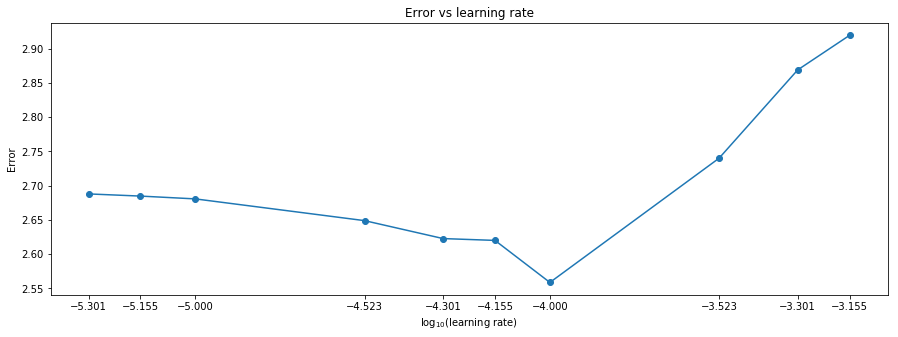

In [10]:
# learning rate vs error
batch_size = 50
iterations = 100
lambd = 0
err_func = "mae"
lr_list = np.array([7e-4,5e-4,3e-4,1e-4,7e-5,5e-5,3e-5,1e-5,7e-6,5e-6])
xa = []
ya = []
for i in lr_list:
    learning_rate = i
    w_grad, err_list = gradient_descent(design_matrix[:N,:], t[:N], learning_rate, batch_size, iterations, M, lambd, err_func)
    ya.append(0.5 * (np.sum(np.abs(np.dot(design_matrix,w_grad) - t[:N]))) / N)
    xa.append(i)
plt.figure(figsize=(15,5))
plt.plot(np.log10(xa),ya,'-o')
plt.title('Error vs learning rate')
plt.xlabel('log$_{10}$(learning rate)')
plt.ylabel('Error')
#plt.ylim((-0.9,20))
plt.xticks(np.log10(xa))
#plt.savefig('100/learning_rate_vs_error.png')
#plt.show()

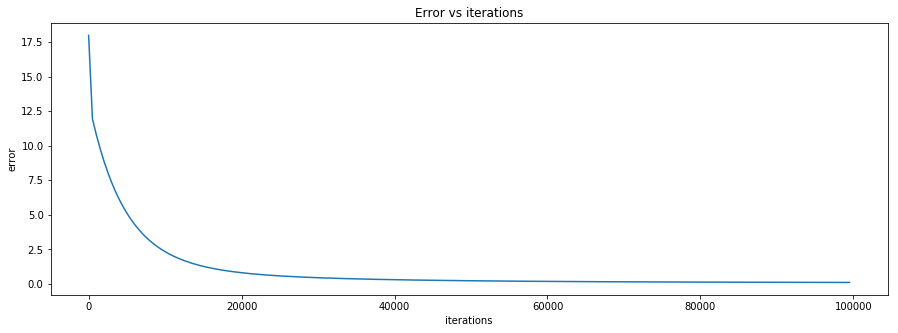

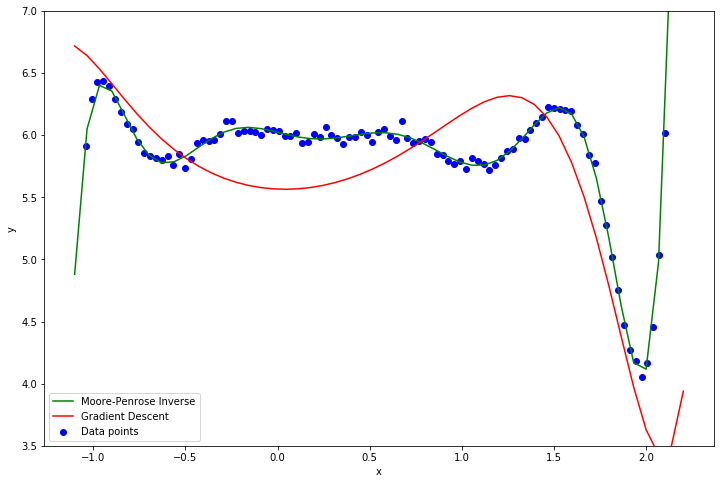

In [11]:
 def poly(x,w):
    y = 0
    for i in range(len(w)):
        y += w[i]*(x**i)
    return y

w_moore,w_grad = linear_regression(design_matrix[:N,:],t[:N]) 

xa = np.linspace(-1.1,2.2,50)
plt.figure(figsize = (12,8))
plt.scatter(x[:N],t[:N], c='b', label = 'Data points')
plt.plot(xa, poly(xa,w_moore), c = 'g', label = 'Moore-Penrose Inverse')
plt.plot(xa, poly(xa,w_grad), c = 'r', label = 'Gradient Descent')
plt.ylim((3.5,7))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
#plt.savefig('100/polynomial.png')
#plt.show()

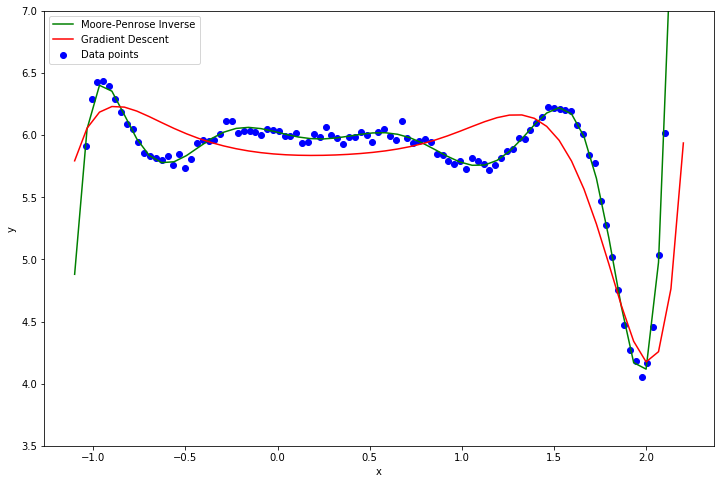

In [174]:
# 5 fold cross validation for w
K = 5
data_shuffled = np.concatenate([design_matrix,t], axis = 1)
#np.random.shuffle(data_shuffled)

train_err = []
test_err = []
min_err = np.inf
for j in range(5):
    train = np.concatenate([data_shuffled[:j*(N//K)], data_shuffled[(j+1)*(N//K):]])
    test = data_shuffled[j*(N//K) : (j+1)*(N//K)]
    design_matrix_train = train[:,0:M]
    t_train = train[:,M]
    design_matrix_test = test[:,0:M]
    t_test = test[:,10]
    t_train = t_train.reshape(len(t_train),1)
    t_test = t_test.reshape(len(t_test),1)
    
    learning_rate = 5e-5  
    batch_size = 50
    lambd = 0
    iterations = 300000
    err_func = "mse"
    w_grad, el = gradient_descent(design_matrix_train, t_train, learning_rate, batch_size, iterations, M, lambd, err_func)
    y_grad_train = np.dot(design_matrix_train,w_grad)
    y_grad_test = np.dot(design_matrix_test,w_grad)
    tr_e = 0.5 * (np.sum(np.square(y_grad_train - t_train)))/ (N-N//K)
    te_e = 0.5 * (np.sum(np.square(y_grad_test - t_test)))/ (N//K)
    if te_e < min_err:
        w_gd = w_grad
        min_err = te_e

xa = np.linspace(-1.1,2.2,50)
plt.figure(figsize = (12,8))
plt.scatter(x[:N],t[:N], c='b', label = 'Data points')
plt.plot(xa,np.polyval(w_moore[::-1],xa), c = 'g', label = 'Moore-Penrose Inverse')
plt.plot(xa,np.polyval(w_gd[::-1],xa), c = 'r', label = 'Gradient Descent')
plt.ylim((3.5,7))
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
#plt.savefig('100/polynomial_cv.png')
#plt.show()

In [176]:
print("Weights using pseudo-inverse - ", w_moore.T)
print("Weights using gradient descent - ", w_gd.T)

Weights using pseudo-inverse -  [[ 6.0233609  -0.37174288 -0.11000579  4.00058653 -2.67908219 -7.87699214
   7.13336258  2.93891574 -4.33254939  1.0520062 ]]
Weights using gradient descent -  [[ 5.84649192 -0.10876973  0.34746953 -0.21591833  0.03520509  0.0769624
   0.17398397  0.09539514 -0.31807073  0.10534444]]


In [167]:
print("moore-penrose error =",0.5 * (np.sum(np.square(np.dot(design_matrix,w_moore) - t[:N]))) / N)
print("gradient descent error =",0.5 * (np.sum(np.square(np.dot(design_matrix,w_gd) - t[:N]))) / N)
#print("gradient descent error =",0.5 * (np.sum(np.abs(np.dot(design_matrix,w_grad) - t[:N]))) / N)

moore-penrose error = 0.0006584089244102429
gradient descent error = 0.15255758460990365


Variance of noise =  0.0013168178488204632
Mean of noise =  -4.738116423652627e-09


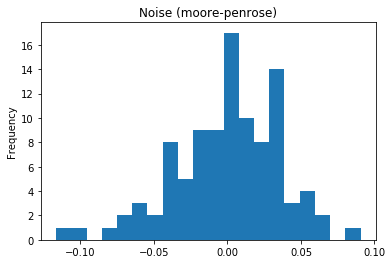

In [150]:
noise_g = np.dot(design_matrix,w_grad) - t[:N]
noise_m = np.dot(design_matrix,w_moore) - t[:N]
print("Variance of noise = ",np.var(noise_m))
print("Mean of noise = ",np.mean(noise_m))


plt.figure
plt.hist(noise_m, bins=20)
plt.title('Noise (moore-penrose)')
plt.ylabel('Frequency')
#plt.savefig('100/noise.png')
#plt.show()

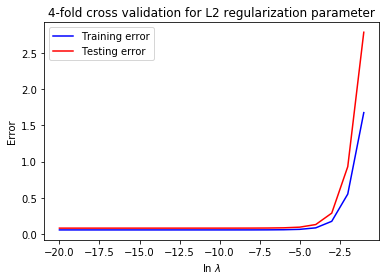

In [61]:
# k fold cross validation for lambda
K = 4
data_shuffled = np.concatenate([design_matrix[:N,:],t[:N]], axis = 1)
#np.random.shuffle(data_shuffled)

train_err = []
test_err = []

lambdas = np.exp(np.arange(-10,0))

for lambd in lambdas:
    tr_e = 0
    te_e = 0
    for j in range(K):
        train = np.concatenate([data_shuffled[:j*(N//k)], data_shuffled[(j+1)*(N//k):]])
        test = data_shuffled[j*(N//k) : (j+1)*(N//k)]
        design_matrix_train = train[:,0:M]
        t_train = train[:,M]
        design_matrix_test = test[:,0:M]
        t_test = test[:,M]
        t_train = t_train.reshape((len(t_train),1))
        t_test = t_test.reshape((len(t_test),1))
                            
         
        #w_mp = np.dot(moore_penrose(design_matrix_train,lambd), t_train)    
        w_mp, w_gd = linear_regression(design_matrix_train,t_train,lambd)
        
        w = w_gd
        y_train = np.dot(design_matrix_train,w)
        y_test = np.dot(design_matrix_test,w)
        tr_e += (0.5 * (np.sum(np.square(y_train - t_train))) + lambd/2 * (np.sum(np.square(w)))) / (N-N//K)
        te_e += (0.5 * (np.sum(np.square(y_test - t_test))) + lambd/2 * (np.sum(np.square(w)))) / (N//K)

    train_err.append(tr_e/5)
    test_err.append(te_e/5)
xa = np.log(lambdas)
plt.plot(xa,train_err,'b', label = "Training error")
plt.plot(xa,test_err,'r', label = "Testing error")
plt.xlabel('ln $\lambda$')
plt.ylabel('Error')
#plt.ylim((-0.001,0.2))
plt.title(str(K) + '-fold cross validation for L2 regularization parameter')
plt.legend()
#plt.savefig('20/lambda.png')
#plt.show()

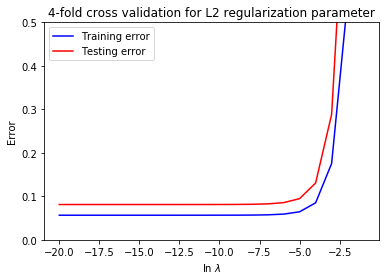

In [68]:
xa = np.log(lambdas)
plt.plot(xa,train_err,'b', label = "Training error")
plt.plot(xa,test_err,'r', label = "Testing error")
plt.xlabel('ln $\lambda$')
plt.ylabel('Error')
plt.ylim((0,0.5))
plt.title(str(K) + '-fold cross validation for L2 regularization parameter')
plt.legend()
#plt.savefig('20/lambda.png')
#plt.show()